# Building a Dog Breed Classifier 
## Convolutional Neural Networks and Transfer Learning

Here I develop an algorithm that identifies the breed of a dog, given its image. In order to do so, I use CNN and simple ANN as well as Transfer Learning. The final implementation of the algorithm is at the end. 

This implementation was part of the assignment in Deep Learning, in order to receive ["Machine Learning Engineer"](https://www.udacity.com/course/machine-learning-engineer-nanodegree--nd009t) Nanodegree by [udacity](https://www.udacity.com/). In this notebook, I make the first steps towards developing an algorithm that could potentially be used as part of a mobile or web app.  At the end of this project, my code accepts any user-supplied image as input. If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling. 

## The steps
 
* [Step 0](#step0): Import and Explore the Datasets.
* [Step 1](#step1): Detect Humans in a Picture.
* [Step 2](#step2): Detect Dogs in a Picture.
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch).
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning).
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning).
* [Step 6](#step6): Develop the Final Algorithm.
* [Step 7](#step7): Test the Final Algorithm.

<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, I import a dataset of dog images. Then, I populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, I import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
import os

cwd = os.getcwd()

random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

Here I use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  I have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, I use this detector to find human faces in a sample image.

Number of faces detected: 1


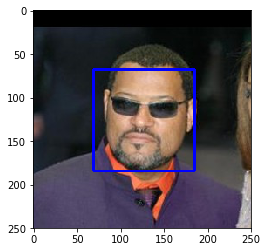

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])

# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY, 0)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is a standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

Now, I can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

###   Assess the Human Face Detector

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  We see that this algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`. When running the cell below we see that 99% of humans were detected and 11% of dogs have been identified as humans.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

n_humans = 0

for im in human_files_short:
    if face_detector(im):
        n_humans += 1

print('Percentage of identified humans: {}'.format(n_humans/100))

n_dogs = 0

for im in dog_files_short:
    if face_detector(im):
        n_dogs += 1 

print('Percentage of dogs identified as humans: {}'.format(n_dogs/100))

Percentage of identified humans: 0.99
Percentage of dogs identified as humans: 0.11


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, I use the pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images. The first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [7]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that I have a way to format our image for supplying to ResNet-50, I am now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, I need only to check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path

def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

I use the code cell below to test the performance of the `dog_detector` function. Running the code cell we see that 
- 1% of the images in `human_files_short` have a detected dog, which is not true.  
- 100% of the images in `dog_files_short` have a detected dog.

In [10]:
### Here I test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

n_humans = 0

for im in human_files_short:
    if dog_detector(im):
        n_humans += 1

print('Percentage of humans identified as dogs: {}%'.format(n_humans))

n_dogs = 0

for im in dog_files_short:
    if dog_detector(im):
        n_dogs += 1 

print('Percentage of identified dogs: {}%'.format(n_dogs))

Percentage of humans identified as dogs: 1%
Percentage of identified dogs: 100%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that the have functions for detecting humans and dogs in images have been developed, we need a way to predict their breed from images.  In this step, I create a CNN that classifies dog breeds from scratch, so that I can't use transfer learning yet! This task is computationaly expensive.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

Something interesting to be mentioned is that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

Another thing to mentionis that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  


### Pre-process the Data

I rescale the images by dividing every pixel in every image by 255.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|███████████████████████████████████████████████████████████████████████████████| 836/836 [00:06<00:00, 130.04it/s]


### Model Architecture

On the cell below, I create a CNN to classify dog breed.  At the end of the code cell block, I summarize the layers of your model by executing the line:
    
        model.summary()

In general the architecture that I developed doesn't seem to be very deep and it consists a good candidate architecture for the clasification task. 

First, the input convolutional layer scans through the image and tries to capture some very basic features. Then, the next layer consists of even more filters and tries to capture more complex features. This may also be show by the fact that the parameters of the second layer are ten times more than the parameters of the first layer. Finally, the last and bigest layer tries to capture even more complex features and probably how the features learned from the first two convolutional layers can be combined. 

Instead of just flatteting the layer, I used the GlobalAveragePooling2D because global average pooling is more meaningful and interpretable as it enforces correspondance between feature maps and categories and in general is more effective according to this paper: https://arxiv.org/pdf/1312.4400.pdf .An interesting addition here is that I have also added some Dropout (~15%), and this is done to avoid overfitting. 

Finally, since this is a classification task and the number of classes are 133, then the last layer is a simple dense layer of 133 nodes. Note that the activation function here is softmax and not relu.

In [12]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

# First input and convolutional layer

model.add(Conv2D(filters = 16, kernel_size = 2, padding = 'same', activation = 'relu',
                 input_shape = (224, 224, 3)))
model.add(MaxPooling2D(pool_size = 2))

# Second convolutional layer

model.add(Conv2D(filters = 32, kernel_size = 2, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))

# Third convolutional layer with Dropout. The 'Flatening' takes place at the GlobalAveragePooling2D layer.
#Dropout is also added

model.add(Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.15))

# Final and classification layer. Softmax activation function is added.

model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [13]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

The model is trained in the code cell below.  I Use model checkpointing to save the model that attains the best validation loss.

In [ ]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 12

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only = True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [15]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

I try out the model on the test dataset of dog images. 

In [16]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 5.0239%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, I now train a CNN using transfer learning. 

### Obtain Bottleneck Features

In [17]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  I only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [18]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [19]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [21]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, I can use the CNN to test how well it identifies breed within our test dataset of dog images.  I print the test accuracy below.

In [22]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 48.2057%


Note that the accuracy from 5.98% is increased to 50.83%!

### Predict Dog Breed with the Model
 Now I test whether the new model can predict dog bree in the following picture. Running the code cell below we see that it is indeed succeesful. 

In [23]:
from extract_bottleneck_features import *

def VGG16_predict_breed(i_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(i_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [24]:
VGG16_predict_breed('images/Brittany_02625.jpg')

'Irish_red_and_white_setter'

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

I now use transfer learning to create a CNN that can identify dog breed from images.  

In Step 4, I used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, I use the bottleneck features from a different pre-trained model.  To make things easier, the features have been pre-computed the features for all of the networks that are currently available in Keras:
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features

The files are encoded as such:

    DogResNet-50Data.npz

### Obtain Bottleneck Features

I chose the Resnet50  architecture and in the code block below, I extract the bottleneck features corresponding to the train, test.

In [25]:
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_ResNet_model = bottleneck_features['train']
valid_ResNet_model = bottleneck_features['valid']
test_ResNet_model = bottleneck_features['test']

### Model Architecture

Create a CNN to classify dog breed.  At the end of the code cell block, summarize the layers of your model by executing the line:
    
            ResNet_model.summary()
   
I loaded the resnet architecture. This model was first introduced in 2015 by Heet al in [their paper](https://arxiv.org/abs/1512.03385). Even though this architecture is much deeper than VGG16 and VGG19, its size is substantially smaller due to the the usage of global average pooling layer rather than fully connected layers (this is the reason why the size is down to 102MB). After the GlobalAveragePooling2D I added a dense layer consisting of 250 nodes with a hyperbolic tangent funtion. I used this function because it has bigger derivatives than the simple sigmoid and thus it is faster for such computationally expensive projects. After the activation function I added a dropout layer of 15% in order to avoid potential overfitting. At the end, since I have 133 classes, my last layer should also have this number of classes.



In [26]:
### Define the architecture.
from keras.layers import Activation

ResNet_model = Sequential()
ResNet_model.add(GlobalAveragePooling2D(input_shape=train_ResNet_model.shape[1:]))
ResNet_model.add(Dense(250))
ResNet_model.add(Activation("tanh"))
ResNet_model.add(Dropout(0.15))
ResNet_model.add(Dense(133, activation='softmax'))
ResNet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 250)               512250    
_________________________________________________________________
activation_50 (Activation)   (None, 250)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               33383     
Total params: 545,633
Trainable params: 545,633
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [27]:
ResNet_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

I train the model in the code cell below.  I also use model checkpointing to save the model that attains the best validation loss. 

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best_ResNet_model.hdf5', 
                               verbose=1, save_best_only=True)

epochs = 20
batch_size = 140

ResNet_model.fit(train_ResNet_model, train_targets, 
          validation_data=(valid_ResNet_model, valid_targets),
          epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss

In [29]:
ResNet_model.load_weights('saved_models/weights.best_ResNet_model.hdf5')

### Test the Model

Here, I try out the model on the test dataset of dog images. 

In [30]:
### Calculate classification accuracy on the test dataset.
ResNet_predictions = [np.argmax(ResNet_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet_model]

# report test accuracy
test_accuracy = 100*np.sum(np.array(ResNet_predictions)==np.argmax(test_targets, axis=1))/len(ResNet_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.9713%


### Predict Dog Breed with the Model

Below I write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, the function has three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [31]:
### Here, I write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def ResNet_breed_prediction(i_path):
    
    '''
    First I extract bottleneck features using the exctract_Resnet50 function.
    Then we obtain the predicted vector. Finally, we return the dog breed that is predicted by the model.
    
    '''

    bottleneck_feature = extract_Resnet50(path_to_tensor(i_path))
    predicted_vector = ResNet_model.predict(bottleneck_feature)
    
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write the Final Algorithm

Here I develop an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed and open a page at google to search about this breed.
- if a __human__ is detected in the image, return the resembling dog breed and open a page at google to search about this breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In [32]:
import webbrowser
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time


def final_algorithm(img_path):    
    '''
    I use the face and dog detector functions defined before. 
    If a dog is detected, then the function opens a new tab in the current browser,
    with the google search page that corresponds to this dog breed.
    Apart from that, the function also shows the provided picture.
    '''
    
    assert type(img_path) == str
    
    Img = mpimg.imread(img_path)        
    dog_breed_prediction = ResNet_breed_prediction(img_path)
    
    def open_google_page(prediction):        
        '''
        This function opens a new tab with the google search term.
        '''
        
        webbrowser.open('http://google.com/#q='+prediction)
    
    if face_detector(img_path):
        print('You don\'t look like a dog, do you?')
        
        # Show the imported image
        Image = plt.title('Human')
        plt.imshow(Img)
        
        print('If you were a dog though, you would look like a {}.'.format(dog_breed_prediction))
        print('A new page in google will open so that you can learn more about '+dog_breed_prediction+
              ' which is the dog breed that you mostly look like!')   
        
        # Pause before you open the browser
        
        time.sleep(5)
        open_google_page(dog_breed_prediction)
    
    elif dog_detector(img_path):
        
        # Show the imported image
        Image = plt.title(dog_breed_prediction)
        plt.imshow(Img)
        
        print('This dog is most likely a {}'.format(dog_breed_prediction))
        print('A new page in google will open so that you can learn more about '+dog_breed_prediction)
        
        # Pause before you open the browser
        
        time.sleep(5)
        open_google_page(dog_breed_prediction)
        
    else:
        
        # Show the imported image        
        Image = plt.title('This is not a dog nor a human')
        plt.imshow(Img)
        
        print('No human or dog is detected in this picture!')

---
<a id='step7'></a>
## Step 7: Test the Final Algorithm on Sample Images!

Below the final algorithm is tested at six images. 

It seems that the algoithm worked fine! It was able to identify me as a human. Interesting thing is that when a picture of a camel is provided, the algorithm outputs that there is no human nor a dog detected. In order to further improve the model, we could implement the following:

$\bullet$ Augment the data, probably by rotating. <br\>
$\bullet$ Increase the number of epochs, depending on our computational power. <br\>
$\bullet$ Add more complexity to our model, either by increasing the number of convolutional layers, the number filters, and the number of nodes.

You don't look like a dog, do you?
If you were a dog though, you would look like a American_water_spaniel.
A new page in google will open so that you can learn more about American_water_spaniel which is the dog breed that you mostly look like!


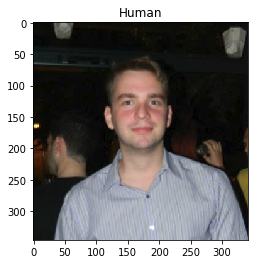

In [33]:
final_algorithm('images/Bar.png')

No human or dog is detected in this picture!


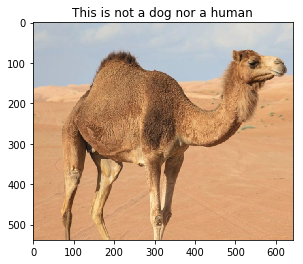

In [34]:
final_algorithm('images/camel.png')

This dog is most likely a Akita
A new page in google will open so that you can learn more about Akita


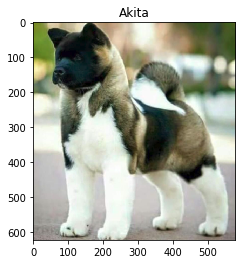

In [36]:
final_algorithm('images/akita_google.png')

This dog is most likely a German_shepherd_dog
A new page in google will open so that you can learn more about German_shepherd_dog


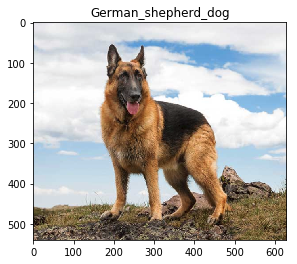

In [37]:
final_algorithm('images/german_shepherd_google.png')

This dog is most likely a Dachshund
A new page in google will open so that you can learn more about Dachshund


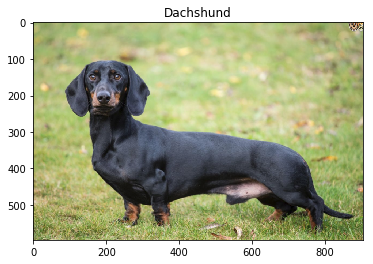

In [39]:
final_algorithm('images/Dachshund_google.png')